**Import dependencies**

In [865]:
# yahoo finance api
import yfinance as yf

# change point detection models
import ruptures as rpt

# S&P 500 company share codes
import company_names

# fuzzy logic
from fuzzylogic.functions import R, S, alpha, triangular, bounded_linear, trapezoid
from fuzzylogic.classes import Domain
from fuzzylogic.hedges import plus, minus, very

# standard libraries
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random
import statistics
import math

In [581]:
del companies

In [584]:
# assign full company names as list
company_name = list(company_names.companies.values())
len(company_name)

503

**0. Functions**

In [526]:
# get stock price 
def preprocessing(stock_name, start_date, end_date):
    
    '''
    1. Input stock name and time window.
    2. Return historical closing price as list for given time window.
    '''

    # assign company
    data = yf.Ticker(stock_name)
    
    # get historical stock data during given time window
    df = data.history(interval = '1d', start = start_date, end = end_date)

    # convert df column to array
    series_array = np.array(round(df['Close'], 4))
    
    # convert df column to list
    column = round(df['Close'], 4)

    return series_array, column

In [713]:
## TO BE DELETED
def get_data(stock_name='TSLA', period='max'):
    
    '''
    1. Input stock name.
    2. Return historical closing price as list.
    '''

    # assign company
    hist = yf.Ticker(stock_name)

    # get historical stock data
    df = hist.history(period)

    # convert df column to list
    series = list(round(df['Close'], 4))
    
    dates = list(df.index)

    return series, dates

In [531]:
# get stock price 
def get_data(stock_name='TSLA', period='max'):
    
    '''
    1. Input stock name.
    2. Return historical closing price as list.
    '''

    # assign company
    hist = yf.Ticker(stock_name)

    # get historical stock data
    df = hist.history(period)

    # convert df column to list
    series = list(round(df['Close'], 4))

    return series

In [3]:
def get_predicted_change_points(stock_name, start_date, end_date, search_method, n_change_points):
    '''
    1. Input stock name, time window, search method and number of change points to detect.
    2. Return index of predicted change points.
    '''
    # number of change points to detect
    n_breaks = n_change_points

    # get stock data of given time window as series and df column
    series, column = preprocessing(stock_name, start_date, end_date)

    # get predicted change points by index
    model = search_method(model="l1").fit(series)
    change_points = model.predict(n_bkps=n_breaks-1)

    return change_points, column

In [722]:
def get_predicted_change_points_calibration(stock_name, start_date, end_date, search_method, width, n_change_points):
    '''
    1. Input stock name, time window, search method and number of change points to detect.
    2. Return index of predicted change points.
    '''
    # number of change points to detect
    n_breaks = n_change_points

    # get stock data of given time window as series and df column
    series, column = preprocessing(stock_name, start_date, end_date)

    # get predicted change points by index
    model = search_method(width=width, model="l1").fit(series)
    change_points = model.predict(n_bkps=n_breaks-1)

    return change_points, column

In [906]:
def mean_squared_error(annotated_change_points, predicted_change_points):
    '''
    1. Input human-labeled change points and predicted change points.
    2. Return mean squared error between human-labeled change points and predicted change points.
    '''
    y = annotated_change_points
    y_bar = predicted_change_points
    
    # variable to store the summation of differences
    summation = 0 
    
    # find total number of items in list
    n = len(y) 
    
    # calculate mse values
    for i in range (0,n):  
        difference = y[i] - y_bar[i]  
        squared_difference = difference**2  
        summation = summation + squared_difference
    
    mse = summation/n
    
    return mse

In [5]:
def index_to_datetime(series, change_points):
    '''
    1. Input change points in index form and corresponding date column.
    2. Return change points in date format.
    '''
    
    f_change_points = []
    
    for i in change_points:
        f_change_points.append(series.index[i-1])

    f_change_points = pd.to_datetime(f_change_points)
    
    return f_change_points

In [31]:
# randomly select a date range within a stock price's min and max date

def select_random_date_range(company):
    '''
    1. Input share code of company.
    2. Return random date range given the min and max date range of the stock.
    '''
    data = yf.Ticker(company)
    #eval_date = data.history(period = 'max', interval = '1d')
    intdate = data.history(period = 'max', interval = '1d')
    mindate = min(intdate.index.date)
    eval_date = data.history(interval = '1d', start = mindate, end = '2021-08-06')
    min_date = min(eval_date.index.date)
    max_date = max(eval_date.index.date)
    
    while True:
        # pick random start date
        time_between_dates = max_date - min_date
        days_between_dates = time_between_dates.days
        random_number_of_days = random.randrange(days_between_dates)
        random_start_date = min_date + timedelta(days=random_number_of_days)
    
        # check whether picked dates are weekend days
        if random_start_date.weekday() != 6 and random_start_date.weekday() != 0:
            break

    while True:
        # pick random end date
        # timedelta(30) to ensure that length of date range is always larger than 50 days
        time_between_dates_2 = max_date - random_start_date - timedelta(days=50)  
        days_between_dates_2 = time_between_dates_2.days
        random_number_of_days_2 = random.randrange(days_between_dates_2)
        random_end_date = random_start_date + timedelta(days=random_number_of_days_2)
        
        if random_start_date.weekday() != 6 and random_start_date.weekday() != 0:
            break

    return random_start_date, random_start_date.weekday(), random_end_date, random_end_date.weekday()

In [13]:
def calc_variability(data, segments):
    '''
    1. Input series and identified segments.
    2. Return list of variabilities for each segment.
    '''

    variability_series = []

    for i in range(len(segments)):
        start, _, end, _ = segments[i]
        x = np.array(data[start:end+1])
        #segment_iqr = round(iqr(x), 4)
        segment_sd = np.std(x)
        segment_avg = np.average(x)
        coefficient_of_variance = round((segment_sd / segment_avg), 2)
        variability_series.append(coefficient_of_variance)

    return variability_series

def calc_slope(segments):
    '''
    1. Input segment series.
    2. Return angle of slope.
    '''
    slope_series = []
    for segment in segments:
        x0, y0, x1, y1 = segment
        angle = round((np.rad2deg(np.arctan2(y1 - y0, x1 - x0))), 2)
        slope_series.append(angle)

    return slope_series

In [14]:
# define membership functions for trend direction

slope = Domain("slope", -90, 90, res=0.01)
slope.decreased_very_quickly = S(-90+30, -90+35)
slope.decreased_quickly = trapezoid(-60, -55, -40, -35)
slope.decreased = trapezoid(-40, -35, -15, -10)
slope.decreased_slowly = trapezoid(-15, -10, -5, 0)
slope.stable = triangular(-1, 1)
slope.increased_slowly = trapezoid(0, 5, 10, 15)
slope.increased = trapezoid(10, 15, 35, 40)
slope.increased_quickly = trapezoid(35, 40, 55, 60)
slope.increased_very_quickly = R(90-35, 90-30)

# define membership functions for variability

variability = Domain("variability", 0, 1, res=0.01)
variability.very_high = R(0.75, 4/5)
variability.high = trapezoid(0.55, 3/5, 0.75, 4/5)
variability.medium = trapezoid(0.35, 2/5, 0.55, 3/5)
variability.low = trapezoid(0.15, 1/5, 0.35, 2/5)
variability.very_low = S(0.15, 1/5)


def fuzzy_slope(series):
    '''
    1. Input series.
    2. Run fuzzy logic evaluation for trend direction and select linguistic label with highest membership degree.
    3. Return linguistic variables (fuzzy labels) and corresponding membership degree.
    '''

    variables = []
    t_values = []

    for i in series:

        total_sum = {'decreased very quickly' : [],
             'decreased quickly' : [],
             'decreased' : [],
             'decreased slowly' : [],
             'remained stable' : [],
             'increased slowly' : [],
             'increased' : [],
             'increased quickly' : [],
             'increased very quickly' : []}

        # change wording of membership functions
        total_sum['decreased very quickly'].append(round(slope.decreased_very_quickly(i), 2))

        total_sum['decreased quickly'].append(round(slope.decreased_quickly(i), 2))

        total_sum['decreased'].append(round(slope.decreased(i), 2))

        total_sum['decreased slowly'].append(round(slope.decreased_slowly(i), 2))

        total_sum['remained stable'].append(round(slope.stable(i), 2))

        total_sum['increased slowly'].append(round(slope.increased_slowly(i), 2))

        total_sum['increased'].append(round(slope.increased(i), 2))

        total_sum['increased quickly'].append(round(slope.increased_quickly(i), 2))

        total_sum['increased very quickly'].append(round(slope.increased_very_quickly(i), 2))

        # get category with highest value
        candidate = max(total_sum, key = lambda x: sum(total_sum.get(x)))
        t_values.append(total_sum.get(max(total_sum, key = lambda x: sum(total_sum.get(x)))))
        candidate_dict = total_sum

        variables.append((candidate, candidate_dict))

    return variables, t_values


def fuzzy_variability(series):
    
    '''
    1. Input series.
    2. Run fuzzy logic evaluation for variability and select linguistic label with highest membership degree.
    3. Return linguistic variables (fuzzy labels) and corresponding membership degree.
    '''

    variables = []
    t_values = []

    for i in series:

        total_sum = {'very high' : [],
                     'high' : [],
                     'medium' : [],
                     'low' : [],
                     'very low' : []}

        total_sum['very high'].append(round(variability.very_high(i), 2))
        total_sum['high'].append(round(variability.high(i), 2))
        total_sum['medium'].append(round(variability.medium(i), 2))
        total_sum['low'].append(round(variability.low(i), 2))
        total_sum['very low'].append(round(variability.very_low(i), 2))


        # get category with highest value
        candidate = max(total_sum, key = lambda x: sum(total_sum.get(x)))
        t_values.append(total_sum.get(max(total_sum, key = lambda x: sum(total_sum.get(x)))))
        candidate_dict = total_sum

        variables.append((candidate, candidate_dict))

    return variables, t_values

In [15]:
def create_segments(breaks, df):
    '''
    1. Input change point indexes and df.
    2. Return segments.
    '''
    segments = []
    start = df.index[0]
    index = list(df.index)
    
    for breakpoint in breaks:
        segment = (index.index(start), round(df[start], 4), index.index(breakpoint), round(df[breakpoint], 4))
        segments.append(segment)
        start = breakpoint
        
    if df.index[-1] != breaks[-1]:
        final = df.index[-1]
        segment = (index.index(breaks[-1]), round(df[breaks[-1]], 4), index.index(final), round(df[final], 4))
        segments.append(segment)
    return segments

In [16]:
# summary generation

def membership_degree(column, segments):
    '''
    1. Input df column and segments.
    2. Calculate membership degree for each attribute (trend direction, variability) for an entire summary.
    3. Return average membership degree of summary.
    '''
    
    # get slope of each segment and calculate corresponding fuzzy variable
    slopes = calc_slope(segments)
    _ , slope_truth_values  = fuzzy_slope(slopes)

    # get variability of each segment
    variabilities = calc_variability(column, segments)
    _ , variability_truth_values = fuzzy_variability(variabilities)
    
    # convert list of lists to list
    slope_truth_values = [item for sublist in slope_truth_values for item in sublist]
    variability_truth_values = [item for sublist in variability_truth_values for item in sublist]
    
    # calculate average membership degree
    summation = sum(slope_truth_values) + sum(variability_truth_values)
    length = len(slope_truth_values + variability_truth_values)
    avg = round(summation/length, 2)

    return avg

**Part 0: General Statistics of Dataset**

In [714]:
series, dates = get_data('NFLX')

In [613]:
# get average length of dataset using all companies of S&P 500 index

lengths = []
variances = []
max_min_ranges = []

for i in range(len(company_name)):
    print('company nr: ', i)
    
    # get stock price times series
    candidate = get_data(company_name[i])
    
    # get variance of stock and append to list
    variance = statistics.variance(candidate)
    variances.append(variance)
    
    # get length of stock and append to list
    lengths.append(len(candidate))
    
    # identify max and min value
    min_value = min(candidate)
    max_value = max(candidate)
    max_min_range = max_value - min_value
    max_min_ranges.append(max_min_range)

company nr:  0
company nr:  1
company nr:  2
company nr:  3
company nr:  4
company nr:  5
company nr:  6
company nr:  7
company nr:  8
company nr:  9
company nr:  10
company nr:  11
company nr:  12
company nr:  13
company nr:  14
company nr:  15
company nr:  16
company nr:  17
company nr:  18
company nr:  19
company nr:  20
company nr:  21
company nr:  22
company nr:  23
company nr:  24
company nr:  25
company nr:  26
company nr:  27
company nr:  28
company nr:  29
company nr:  30
company nr:  31
company nr:  32
company nr:  33
company nr:  34
company nr:  35
company nr:  36
company nr:  37
company nr:  38
company nr:  39
company nr:  40
company nr:  41
company nr:  42
company nr:  43
company nr:  44
company nr:  45
company nr:  46
company nr:  47
company nr:  48
company nr:  49
company nr:  50
company nr:  51
company nr:  52
company nr:  53
company nr:  54
company nr:  55
company nr:  56
company nr:  57
company nr:  58
company nr:  59
company nr:  60
company nr:  61
company nr:  62
co

company nr:  489
company nr:  490
company nr:  491
company nr:  492
company nr:  493
company nr:  494
company nr:  495
company nr:  496
company nr:  497
company nr:  498
company nr:  499
company nr:  500
company nr:  501
company nr:  502


In [617]:
# calculate average length of time series
print(round(sum(lengths) / len(lengths), 2))

# calculate average max-min range of stock prices
print(round(sum(max_min_ranges) / len(lengths), 2))

# calculate average variance of stock price
print(round(sum(variances) / len(lengths), 2))

7983.52
222.86
9380.95


**Part 1: Change Point Precision for 30 randomly sampled companies**

A) Get predicted change points by all four search methods

In [529]:
'''
Randomly sample 30 different companies with different time series lengths and
collect detected change points by all 4 search methods.
'''
# set random seed
random.seed(29)

n_change_points = 4
results_predicted = {}
random_dates = []

for i in range(30):
    results_predicted[i] = {}
    
    random_company = random.choice(company_name)
    results_predicted[i]['company'] = random_company
    
    # pick random date range given company's min and max stock date
    start_date, _ , end_date, _ = select_random_date_range(random_company)
    results_predicted[i]['date'] = (start_date, end_date)
    random_dates.append((start_date, end_date))
    
    # run change point detection by top-down method
    topdown_change_points, column = get_predicted_change_points(random_company, start_date, end_date, rpt.Binseg, n_change_points)
    results_predicted[i]['series'] = column
    results_predicted[i]['top-down'] = topdown_change_points
    results_predicted[i]['top-down (datetime)'] = index_to_datetime(column, topdown_change_points)
    
    # run change point detection by bottom-up method
    bottomup_change_points, _ = get_predicted_change_points(random_company, start_date, end_date, rpt.BottomUp, n_change_points)
    results_predicted[i]['bottom-up'] = bottomup_change_points
    results_predicted[i]['bottom-up (datetime)'] = index_to_datetime(column, bottomup_change_points)
    
    # run change point detection by window sliding method
    window_change_points, _ = get_predicted_change_points(random_company, start_date, end_date, rpt.Window, n_change_points)
    results_predicted[i]['window'] = window_change_points
    results_predicted[i]['window (datetime)'] = index_to_datetime(column, window_change_points)
    
    # run change point detection by optimal method
    optimal_change_points, _ = get_predicted_change_points(random_company, start_date, end_date, rpt.Dynp, n_change_points)
    results_predicted[i]['optimal'] = optimal_change_points
    results_predicted[i]['optimal (datetime)'] = index_to_datetime(column, optimal_change_points)
    
    print('Run number:', i)

Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
Run number: 15
Run number: 16
Run number: 17
Run number: 18
Run number: 19
Run number: 20
Run number: 21
Run number: 22
Run number: 23
Run number: 24
Run number: 25
Run number: 26
Run number: 27
Run number: 28
Run number: 29


In [898]:
# set random seed
random.seed(29)

n_change_points = 4
results_predicted = {}
random_dates = []

for i in range(30):
    results_predicted[i] = {}
    
    random_company = random.choice(company_name)
    results_predicted[i]['company'] = random_company
    
    # pick random date range given company's min and max stock date
    start_date, _ , end_date, _ = select_random_date_range(random_company)
    results_predicted[i]['date'] = (start_date, end_date)
    random_dates.append((start_date, end_date))
    
    # run change point detection by top-down method
    topdown_change_points, column = get_predicted_change_points(random_company, start_date, end_date, rpt.Binseg, n_change_points)
    results_predicted[i]['series'] = column
    results_predicted[i]['top-down'] = topdown_change_points
    results_predicted[i]['top-down (datetime)'] = index_to_datetime(column, topdown_change_points)
    
    # run change point detection by bottom-up method
    bottomup_change_points, _ = get_predicted_change_points(random_company, start_date, end_date, rpt.BottomUp, n_change_points)
    results_predicted[i]['bottom-up'] = bottomup_change_points
    results_predicted[i]['bottom-up (datetime)'] = index_to_datetime(column, bottomup_change_points)
    
    # run change point detection by window sliding method
    window_change_points, _ = get_predicted_change_points(random_company, start_date, end_date, rpt.Window, n_change_points)
    results_predicted[i]['window'] = window_change_points
    results_predicted[i]['window (datetime)'] = index_to_datetime(column, window_change_points)
    
    # run change point detection by optimal method
    optimal_change_points, _ = get_predicted_change_points(random_company, start_date, end_date, rpt.Dynp, n_change_points)
    results_predicted[i]['optimal'] = optimal_change_points
    results_predicted[i]['optimal (datetime)'] = index_to_datetime(column, optimal_change_points)
    
    print('Run number:', i)

Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
Run number: 15
Run number: 16
Run number: 17
Run number: 18
Run number: 19
Run number: 20
Run number: 21
Run number: 22
Run number: 23
Run number: 24
Run number: 25
Run number: 26
Run number: 27
Run number: 28
Run number: 29


Plot some of the results

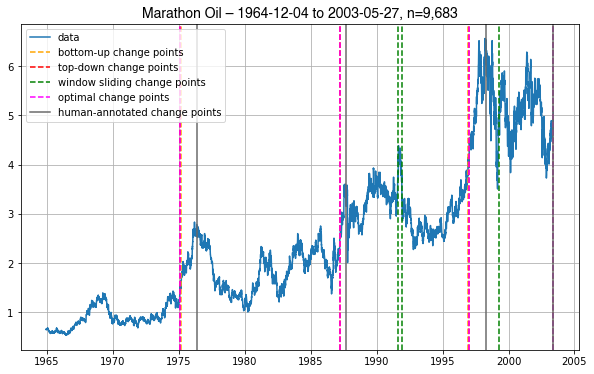

In [177]:
hfont = {'fontname':'Helvetica'}

idx = 0
plt.figure(figsize=(10, 6))
plt.plot(results_predicted[idx]['series'], label='data')
plt.title('Marathon Oil – 1964-12-04 to 2003-05-27, ' + 'n=9,683', size=14, **hfont)
print_legend = True

# plot predicted change points by bottom-up method
for i in results_predicted[idx]['bottom-up (datetime)']:
    if print_legend:
        plt.axvline(i, color='orange', linestyle='dashed', label='bottom-up change points')
        print_legend = False
    else:
        plt.axvline(i, color='orange', linestyle='dashed')
        
print_legend = True
        
# plot predicted change points by top-down method
for i in results_predicted[idx]['top-down (datetime)']:
    if print_legend:
        plt.axvline(i, color='red',linestyle='dashed', label='top-down change points')
        print_legend = False
    else:
        plt.axvline(i, color='red',linestyle='dashed')

print_legend = True

# plot predicted change points by window method
for i in results_predicted[idx]['window (datetime)']:
    if print_legend:
        plt.axvline(i, color='green',linestyle='dashed', label='window sliding change points')
        print_legend = False
    else:
        plt.axvline(i, color='green',linestyle='dashed')

print_legend = True      

# plot predicted change points by optimal method
for i in results_predicted[idx]['optimal (datetime)']:
    if print_legend:
        plt.axvline(i, color='magenta',linestyle='dashed', label='optimal change points')
        print_legend = False
    else:
        plt.axvline(i, color='magenta',linestyle='dashed')
        
print_legend = True      

# plot human-annotated change points
for i in breaks_jkp:
    if print_legend:
        plt.axvline(i, color='dimgray',linestyle='solid', label='human-annotated change points')
        print_legend = False
    else:
        plt.axvline(i, color='dimgray',linestyle='solid')

# print legend
plt.legend()
    
# show grid
plt.grid()

# save fig
plt.savefig('mse_{}.png'.format(idx))

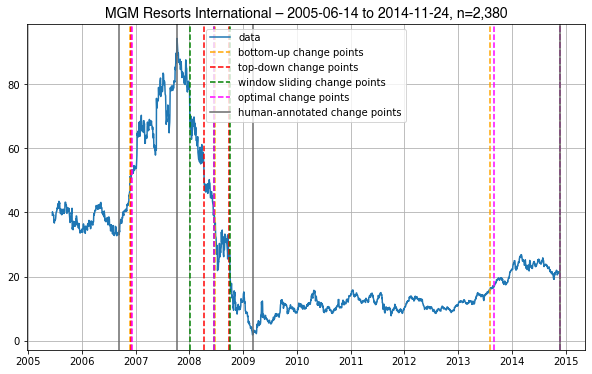

In [224]:
hfont = {'fontname':'Helvetica'}

# idx = 4
idx = 7
plt.figure(figsize=(10, 6))
plt.plot(results_predicted[idx]['series'], label='data')
plt.title('MGM Resorts International – 2005-06-14 to 2014-11-24, ' + 'n=2,380', size=14, **hfont)
#plt.title('Human-Annotated vs. Predicted Change Points, ' + 'n=' + str(len(ts)), size=14, **hfont)
print_legend = True

# plot predicted change points by bottom-up method
for i in results_predicted[idx]['bottom-up (datetime)']:
    if print_legend:
        plt.axvline(i, color='orange', linestyle='dashed', label='bottom-up change points')
        print_legend = False
    else:
        plt.axvline(i, color='orange', linestyle='dashed')
        
print_legend = True
        
# plot predicted change points by top-down method
for i in results_predicted[idx]['top-down (datetime)']:
    if print_legend:
        plt.axvline(i, color='red',linestyle='dashed', label='top-down change points')
        print_legend = False
    else:
        plt.axvline(i, color='red',linestyle='dashed')

print_legend = True

# plot predicted change points by window method
for i in results_predicted[idx]['window (datetime)']:
    if print_legend:
        plt.axvline(i, color='green',linestyle='dashed', label='window sliding change points')
        print_legend = False
    else:
        plt.axvline(i, color='green',linestyle='dashed')

print_legend = True      

# plot predicted change points by optimal method
for i in results_predicted[idx]['optimal (datetime)']:
    if print_legend:
        plt.axvline(i, color='magenta',linestyle='dashed', label='optimal change points')
        print_legend = False
    else:
        plt.axvline(i, color='magenta',linestyle='dashed')
        
print_legend = True      

# plot human-annotated change points
for i in h_change_points:
    if print_legend:
        plt.axvline(i, color='dimgray',linestyle='solid', label='human-annotated change points')
        print_legend = False
    else:
        plt.axvline(i, color='dimgray',linestyle='solid')

# print legend
plt.legend()
    
# show grid
plt.grid()

# save fig
plt.savefig('mse_{}.png'.format(idx))

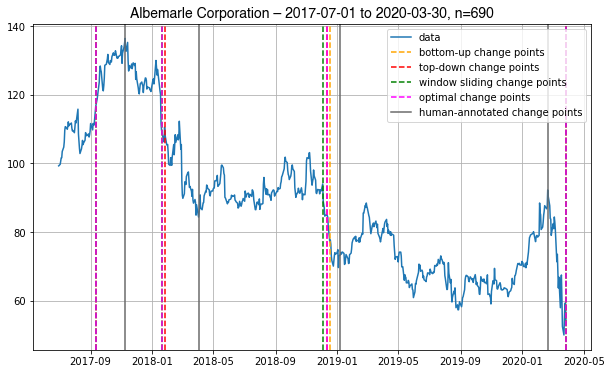

In [231]:
hfont = {'fontname':'Helvetica'}

idx = 4
plt.figure(figsize=(10, 6))
plt.plot(results_predicted[idx]['series'], label='data')
plt.title('Albemarle Corporation – 2017-07-01 to 2020-03-30, ' + 'n=690', size=14, **hfont)
#plt.title('Human-Annotated vs. Predicted Change Points, ' + 'n=' + str(len(ts)), size=14, **hfont)
print_legend = True

# plot predicted change points by bottom-up method
for i in results_predicted[idx]['bottom-up (datetime)']:
    if print_legend:
        plt.axvline(i, color='orange', linestyle='dashed', label='bottom-up change points')
        print_legend = False
    else:
        plt.axvline(i, color='orange', linestyle='dashed')
        
print_legend = True
        
# plot predicted change points by top-down method
for i in results_predicted[idx]['top-down (datetime)']:
    if print_legend:
        plt.axvline(i, color='red',linestyle='dashed', label='top-down change points')
        print_legend = False
    else:
        plt.axvline(i, color='red',linestyle='dashed')

print_legend = True

# plot predicted change points by window method
for i in results_predicted[idx]['window (datetime)']:
    if print_legend:
        plt.axvline(i, color='green',linestyle='dashed', label='window sliding change points')
        print_legend = False
    else:
        plt.axvline(i, color='green',linestyle='dashed')

print_legend = True      

# plot predicted change points by optimal method
for i in results_predicted[idx]['optimal (datetime)']:
    if print_legend:
        plt.axvline(i, color='magenta',linestyle='dashed', label='optimal change points')
        print_legend = False
    else:
        plt.axvline(i, color='magenta',linestyle='dashed')
        
print_legend = True      

# plot human-annotated change points
for i in h_change_points:
    if print_legend:
        plt.axvline(i, color='dimgray',linestyle='solid', label='human-annotated change points')
        print_legend = False
    else:
        plt.axvline(i, color='dimgray',linestyle='solid')

# print legend
plt.legend()
    
# show grid
plt.grid()

# save fig
plt.savefig('mse_{}.png'.format(idx))

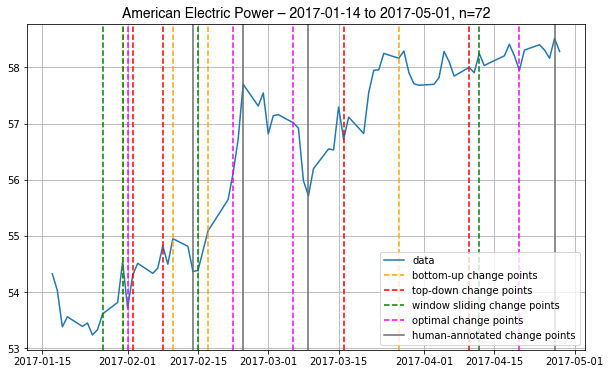

In [293]:
hfont = {'fontname':'Helvetica'}

plt.figure(figsize=(10, 6))
plt.plot(series, label='data')
plt.title('American Electric Power – 2017-01-14 to 2017-05-01, ' + 'n=72', size=14, **hfont)
#plt.title('Human-Annotated vs. Predicted Change Points, ' + 'n=' + str(len(ts)), size=14, **hfont)
print_legend = True

# plot predicted change points by bottom-up method
for i in b_change_points:
    if print_legend:
        plt.axvline(i, color='orange', linestyle='dashed', label='bottom-up change points')
        print_legend = False
    else:
        plt.axvline(i, color='orange', linestyle='dashed')
        
print_legend = True
        
# plot predicted change points by top-down method
for i in t_change_points:
    if print_legend:
        plt.axvline(i, color='red',linestyle='dashed', label='top-down change points')
        print_legend = False
    else:
        plt.axvline(i, color='red',linestyle='dashed')

print_legend = True
#
# plot predicted change points by window method
for i in w_change_points:
    if print_legend:
        plt.axvline(i, color='green',linestyle='dashed', label='window sliding change points')
        print_legend = False
    else:
        plt.axvline(i, color='green',linestyle='dashed')

print_legend = True      
#
# plot predicted change points by optimal method
for i in o_change_points:
    if print_legend:
        plt.axvline(i, color='magenta',linestyle='dashed', label='optimal change points')
        print_legend = False
    else:
        plt.axvline(i, color='magenta',linestyle='dashed')
        
print_legend = True      

# plot human-annotated change points
for i in a_change_points:
    if print_legend:
        plt.axvline(i, color='dimgray',linestyle='solid', label='human-annotated change points')
        print_legend = False
    else:
        plt.axvline(i, color='dimgray',linestyle='solid')

# print legend
plt.legend()
    
# show grid
plt.grid()

# save fig
plt.savefig('mse_9.png')

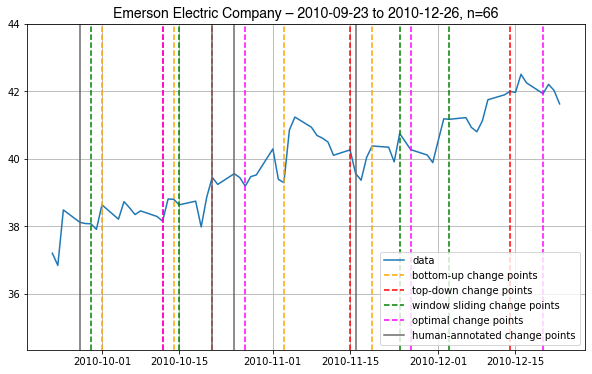

In [410]:
hfont = {'fontname':'Helvetica'}

plt.figure(figsize=(10, 6))
plt.plot(series, label='data')
plt.title('Emerson Electric Company – 2010-09-23 to 2010-12-26, ' + 'n=66', size=14, **hfont)
#plt.title('Human-Annotated vs. Predicted Change Points, ' + 'n=' + str(len(ts)), size=14, **hfont)
print_legend = True

# plot predicted change points by bottom-up method
for i in b_change_points:
    if print_legend:
        plt.axvline(i, color='orange', linestyle='dashed', label='bottom-up change points')
        print_legend = False
    else:
        plt.axvline(i, color='orange', linestyle='dashed')
        
print_legend = True
        
# plot predicted change points by top-down method
for i in t_change_points:
    if print_legend:
        plt.axvline(i, color='red',linestyle='dashed', label='top-down change points')
        print_legend = False
    else:
        plt.axvline(i, color='red',linestyle='dashed')

print_legend = True

# plot predicted change points by window method
for i in w_change_points:
    if print_legend:
        plt.axvline(i, color='green',linestyle='dashed', label='window sliding change points')
        print_legend = False
    else:
        plt.axvline(i, color='green',linestyle='dashed')

print_legend = True      

# plot predicted change points by optimal method
for i in o_change_points:
    if print_legend:
        plt.axvline(i, color='magenta',linestyle='dashed', label='optimal change points')
        print_legend = False
    else:
        plt.axvline(i, color='magenta',linestyle='dashed')
        
print_legend = True      

# plot human-annotated change points
for i in a_change_points:
    if print_legend:
        plt.axvline(i, color='dimgray',linestyle='solid', label='human-annotated change points')
        print_legend = False
    else:
        plt.axvline(i, color='dimgray',linestyle='solid')

# get the y limits
ymin, ymax = min(series), max(series)

# set the y limits making the maximum 5% greater
plt.ylim(ymin-2.5, ymax+1.5)        

# print legend
plt.legend()
    
# show grid
plt.grid()

# save fig
plt.savefig('mse_10.png')

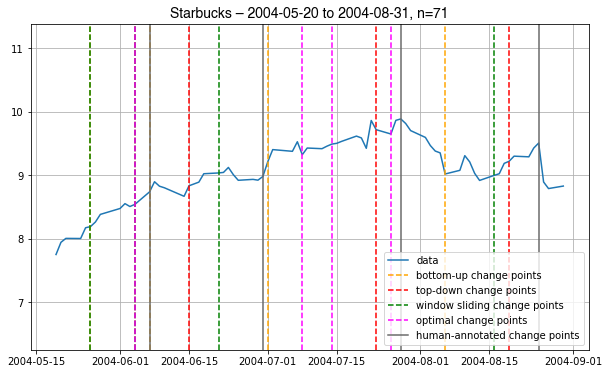

In [519]:
hfont = {'fontname':'Helvetica'}

plt.figure(figsize=(10, 6))
plt.plot(series, label='data')
plt.title('Starbucks – 2004-05-20 to 2004-08-31, ' + 'n=71', size=14, **hfont)
#plt.title('Human-Annotated vs. Predicted Change Points, ' + 'n=' + str(len(ts)), size=14, **hfont)
print_legend = True

# plot predicted change points by bottom-up method
for i in b_change_points:
    if print_legend:
        plt.axvline(i, color='orange', linestyle='dashed', label='bottom-up change points')
        print_legend = False
    else:
        plt.axvline(i, color='orange', linestyle='dashed')
        
print_legend = True
        
# plot predicted change points by top-down method
for i in t_change_points:
    if print_legend:
        plt.axvline(i, color='red',linestyle='dashed', label='top-down change points')
        print_legend = False
    else:
        plt.axvline(i, color='red',linestyle='dashed')

print_legend = True

# plot predicted change points by window method
for i in w_change_points:
    if print_legend:
        plt.axvline(i, color='green',linestyle='dashed', label='window sliding change points')
        print_legend = False
    else:
        plt.axvline(i, color='green',linestyle='dashed')

print_legend = True      

# plot predicted change points by optimal method
for i in o_change_points:
    if print_legend:
        plt.axvline(i, color='magenta',linestyle='dashed', label='optimal change points')
        print_legend = False
    else:
        plt.axvline(i, color='magenta',linestyle='dashed')
        
print_legend = True      

# plot human-annotated change points
for i in a_change_points:
    if print_legend:
        plt.axvline(i, color='dimgray',linestyle='solid', label='human-annotated change points')
        print_legend = False
    else:
        plt.axvline(i, color='dimgray',linestyle='solid')

# get the y limits
ymin, ymax = min(series), max(series)

# set the y limits making the maximum 5% greater
plt.ylim(ymin-1.5, ymax+1.5)

# print legend
plt.legend()
    
# show grid
plt.grid()

# save fig
plt.savefig('mse_11.png')

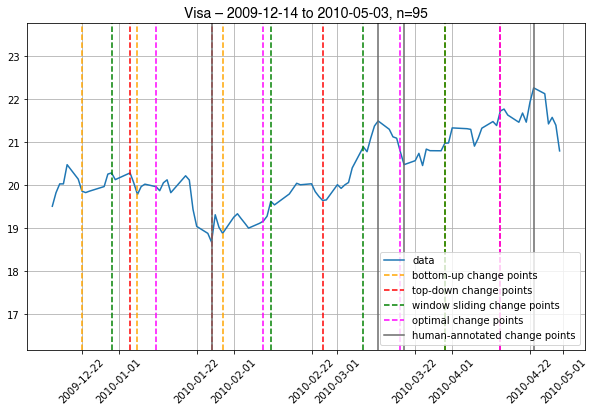

In [501]:
hfont = {'fontname':'Helvetica'}



plt.figure(figsize=(10, 6))
plt.plot(series, label='data')
plt.title('Visa – 2009-12-14 to 2010-05-03, ' + 'n=95', size=14, **hfont)
#plt.title('Human-Annotated vs. Predicted Change Points, ' + 'n=' + str(len(ts)), size=14, **hfont)
print_legend = True

# plot predicted change points by bottom-up method
for i in b_change_points:
    if print_legend:
        plt.axvline(i, color='orange', linestyle='dashed', label='bottom-up change points')
        print_legend = False
    else:
        plt.axvline(i, color='orange', linestyle='dashed')
        
print_legend = True
        
# plot predicted change points by top-down method
for i in t_change_points:
    if print_legend:
        plt.axvline(i, color='red',linestyle='dashed', label='top-down change points')
        print_legend = False
    else:
        plt.axvline(i, color='red',linestyle='dashed')

print_legend = True
# plot predicted change points by window method
for i in w_change_points:
    if print_legend:
        plt.axvline(i, color='green',linestyle='dashed', label='window sliding change points')
        print_legend = False
    else:
        plt.axvline(i, color='green',linestyle='dashed')

print_legend = True      

# plot predicted change points by optimal method
for i in o_change_points:
    if print_legend:
        plt.axvline(i, color='magenta',linestyle='dashed', label='optimal change points')
        print_legend = False
    else:
        plt.axvline(i, color='magenta',linestyle='dashed')
        
print_legend = True      

# plot human-annotated change points
for i in a_change_points:
    if print_legend:
        plt.axvline(i, color='dimgray',linestyle='solid', label='human-annotated change points')
        print_legend = False
    else:
        plt.axvline(i, color='dimgray',linestyle='solid')

# get the y limits
ymin, ymax = min(series), max(series)

# set the y limits making the maximum 5% greater
plt.ylim(ymin-2.5, ymax+1.5)

# plt.xticks(np.arange(1, len(series)+1, 5))
plt.xticks(rotation=45)
# values = range(len(series))
# plt.xticks(1,10)

# print legend
plt.legend()
    
# show grid
plt.grid()

# save fig
plt.savefig('mse_12.png')

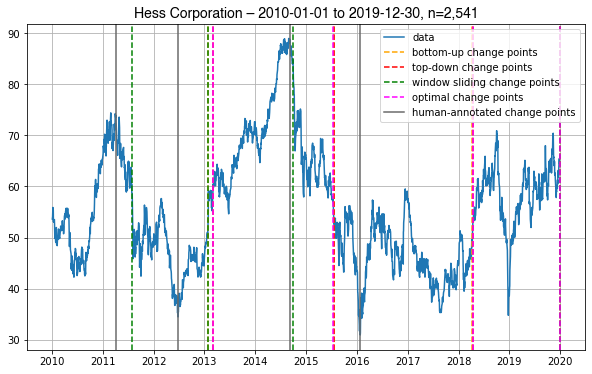

In [970]:
hfont = {'fontname':'Helvetica'}

# idx = 4
idx = 0
plt.figure(figsize=(10, 6))
plt.plot(results_predicted_example[idx]['series'], label='data')
plt.title('Hess Corporation – 2010-01-01 to 2019-12-30, ' + 'n=2,541', size=14, **hfont)
#plt.title('Human-Annotated vs. Predicted Change Points, ' + 'n=' + str(len(ts)), size=14, **hfont)
print_legend = True

# plot predicted change points by bottom-up method
for i in results_predicted_example[idx]['bottom-up (datetime)']:
    if print_legend:
        plt.axvline(i, color='orange', linestyle='dashed', label='bottom-up change points')
        print_legend = False
    else:
        plt.axvline(i, color='orange', linestyle='dashed')
        
print_legend = True
        
# plot predicted change points by top-down method
for i in results_predicted_example[idx]['top-down (datetime)']:
    if print_legend:
        plt.axvline(i, color='red',linestyle='dashed', label='top-down change points')
        print_legend = False
    else:
        plt.axvline(i, color='red',linestyle='dashed')

print_legend = True

# plot predicted change points by window method
for i in results_predicted_example[idx]['window (datetime)']:
    if print_legend:
        plt.axvline(i, color='green',linestyle='dashed', label='window sliding change points')
        print_legend = False
    else:
        plt.axvline(i, color='green',linestyle='dashed')

print_legend = True      

# plot predicted change points by optimal method
for i in results_predicted_example[idx]['optimal (datetime)']:
    if print_legend:
        plt.axvline(i, color='magenta',linestyle='dashed', label='optimal change points')
        print_legend = False
    else:
        plt.axvline(i, color='magenta',linestyle='dashed')
        
print_legend = True      

# plot human-annotated change points
for i in a_change_points:
    if print_legend:
        plt.axvline(i, color='dimgray',linestyle='solid', label='human-annotated change points')
        print_legend = False
    else:
        plt.axvline(i, color='dimgray',linestyle='solid')

# print legend
plt.legend()
    
# show grid
plt.grid()

# save fig
plt.savefig('mse_13.png')
#plt.savefig('mse_{}.png'.format(idx))

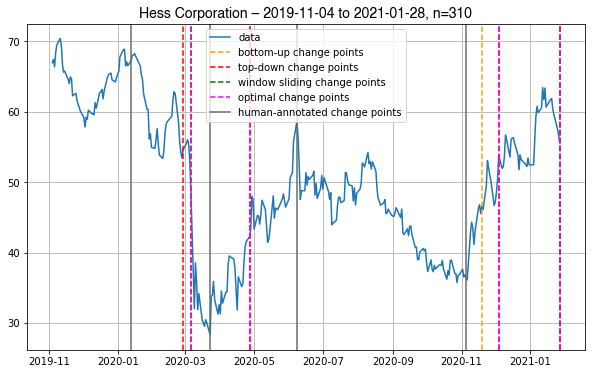

In [963]:
hfont = {'fontname':'Helvetica'}

# idx = 4
idx = 0
plt.figure(figsize=(10, 6))
plt.plot(results_predicted_example[idx]['series'], label='data')
plt.title('Hess Corporation – 2019-11-04 to 2021-01-28, ' + 'n=' + str(len(results_predicted_example[idx]['series'])), size=14, **hfont)
#plt.title('Human-Annotated vs. Predicted Change Points, ' + 'n=' + str(len(ts)), size=14, **hfont)
print_legend = True

# plot predicted change points by bottom-up method
for i in results_predicted_example[idx]['bottom-up (datetime)']:
    if print_legend:
        plt.axvline(i, color='orange', linestyle='dashed', label='bottom-up change points')
        print_legend = False
    else:
        plt.axvline(i, color='orange', linestyle='dashed')
        
print_legend = True
        
# plot predicted change points by top-down method
for i in results_predicted_example[idx]['top-down (datetime)']:
    if print_legend:
        plt.axvline(i, color='red',linestyle='dashed', label='top-down change points')
        print_legend = False
    else:
        plt.axvline(i, color='red',linestyle='dashed')

print_legend = True

# plot predicted change points by window method
for i in results_predicted_example[idx]['window (datetime)']:
    if print_legend:
        plt.axvline(i, color='green',linestyle='dashed', label='window sliding change points')
        print_legend = False
    else:
        plt.axvline(i, color='green',linestyle='dashed')

print_legend = True      

# plot predicted change points by optimal method
for i in results_predicted_example[idx]['optimal (datetime)']:
    if print_legend:
        plt.axvline(i, color='magenta',linestyle='dashed', label='optimal change points')
        print_legend = False
    else:
        plt.axvline(i, color='magenta',linestyle='dashed')
        
print_legend = True      

# plot human-annotated change points
for i in a_change_points:
    if print_legend:
        plt.axvline(i, color='dimgray',linestyle='solid', label='human-annotated change points')
        print_legend = False
    else:
        plt.axvline(i, color='dimgray',linestyle='solid')

# print legend
plt.legend()
    
# show grid
plt.grid()

# save fig
plt.savefig('mse_14.png')
#plt.savefig('mse_{}.png'.format(idx))

B) Label change points based on randomly selected companies in previous task

In [961]:
annotated_change_points = [
    
    #'LDOS', '2008-07-01', '2016-04-03' (1)
    [1174, 1363, 1590, 1874],
    
    # 'MET', '2013-11-05', '2017-01-30' (2)
    [409, 664, 758, 780],
    
    # 'APA' '2002-04-05', '2009-12-20' (3)
    [880,1360, 1545, 1788],

    # 'FOX', '2019-06-27', '2020-09-24' (4)
    [72, 164, 186, 239],
    
    # 'NI', '1993-04-23', '2008-12-27' (5)
    [2392, 3547, 3998, 4192],
    
    # 'AON', '2002-10-02', '2010-02-19' (6)
    [709, 904, 983, 1856],
    
    # 'VRSK', '2019-03-06', '2021-03-22' (7)
    [251, 263, 461, 514],
    
    # 'CMG', '2016-02-06', '2017-01-20' (8)
    [19, 30, 70, 200],
    
    # 'CLX', '2012-01-26', '2020-11-10' (9)
    [1223, 1732, 1990, 2147],
    
    # 'GD', '2012-06-23', '2018-05-07' (10)
    [614, 1101, 1343, 1471],
    
    # 'CHTR', '2019-06-27', '2020-04-27' (11)
    [33, 163, 185, 208],
    
    # 'DLR', '2016-04-22', '2020-07-06' (12)
    [393, 471, 883, 1011],
    
    # 'CLX', '2019-05-29', '2019-10-23' (13)
    # [145, 226, 731, 797],
    [190, 1215, 1500, 1600],
    
    # 'QCOM, '2005-09-21', '2012-06-07' (14)
    # [352, 1385, 1650, 2212],
    [170, 1285, 1500, 1690],
    
    # 'MXIM', '2020-02-19', '2021-04-28' (15)
    [352, 1385, 1650, 2212],
    
    # 'STE', '2020-02-19', '2021-04-28' (16)
    [64, 150, 280, 291],
    
    # 'RHI', '2020-05-14', '2020-07-03' (17)
    [11, 14, 20, 36],
    
    # 'PFG', '2021-01-15', '2021-02-19' (18)
    [4, 10, 20, 23],
    
    # 'DVA', '2002-07-23', '2017-12-31' (19)
    [1331, 1702, 3235, 3857],
    
    # 'EL', '1998-12-25', '2016-10-29' (20)
    [2700, 3000, 3801, 4490],
    
    # 'COF', '2013-06-29', '2020-07-02' (21)
    [754, 1151, 1382, 1671],
    
    # 'NTRS', '1992-10-28', '2020-07-09' (22)
    [2612, 3999, 4014, 6856],
    
    # 'NLOK', '2020-10-31', '2021-04-11' (23)
    [3, 20, 67, 79],
    
    # 'PG', '1980-05-31', '2010-07-17' (24)
    # [4963, 8740, 9587, 10017],
    [2432, 4210, 5981, 7430],
    
    # 'DLR', '2005-03-02', '2005-08-28' (25)
    [60, 78, 102, 120],
    
    # 'GPS', '1998-10-17', '2004-11-20' (26) (example)
    [186, 253, 327, 505], 
    
    # 'HES', '1991-03-23', '1993-08-25' (27) (example)
    [146, 260, 463, 549],
    
    # 'WRK', '2016-01-07', '2020-01-29' (28)
    # [26, 517, 919, 1014],
    [35, 497, 810, 1014],
    
    # 'ALLE', '2015-03-26', '2015-04-25' (29)
    [10, 14, 16, 21],
    
    # 'WBA', '2008-05-16', '2019-12-30' (30) (example)
    [1048, 1817, 2540, 2884],
    
    # 'HES', '2010-01-01', '2019-12-30'
    [318, 627, 1176, 1522],
    
    # 'HES', '2019-11-04' '2021-01-28'
    [47, 95, 148, 254],
]

In [914]:
# calculate mean squared errors between predicted change points and human-annotated change points
mse_topdown = []
mse_bottomup = []
mse_window = []
mse_optimal = []

for i in range(len(results_predicted)):
    
    mse_topdown.append(mean_squared_error(annotated_change_points[i], results_predicted[i]['top-down']))
    mse_bottomup.append(mean_squared_error(annotated_change_points[i], results_predicted[i]['bottom-up']))
    mse_window.append(mean_squared_error(annotated_change_points[i], results_predicted[i]['window']))
    mse_optimal.append(mean_squared_error(annotated_change_points[i], results_predicted[i]['optimal']))

In [930]:
# --- TEST ---
avg_mse_topdown = round(np.average(mse_topdown), 2)
avg_mse_bottomup = round(np.average(mse_bottomup), 2)
avg_mse_window = round(np.average(mse_window), 2)
avg_mse_optimal = round(np.average(mse_optimal), 2)

rmse_topdown = round(math.sqrt(np.average(mse_topdown)), 2)
rmse_bottomup = round(math.sqrt(np.average(mse_bottomup)), 2)
rmse_window = round(math.sqrt(np.average(mse_window)), 2)
rmse_optimal = round(math.sqrt(np.average(mse_optimal)), 2)

In [931]:
methods = ['top-down', 'bottom-up', 'window sliding', 'optimal']
avg_mse = [avg_mse_topdown, avg_mse_bottomup, avg_mse_window, avg_mse_optimal]
rmse = [rmse_topdown, rmse_bottomup, rmse_window, rmse_optimal]

In [932]:
results_mse_df = pd.DataFrame({'methods': methods, 'mse': avg_mse, 'rmse': rmse})
results_mse_df

,methods,mse,rmse
0,top-down,306864.02,553.95
1,bottom-up,338443.27,581.76
2,window sliding,538004.61,733.49
3,optimal,305001.14,552.27


c) Test for different window sizes of window sliding method

In [877]:
# reformat samples generated from the random experiment

samples = [
    
    ['LDOS', '2008-07-01', '2016-04-03'],
    
    ['MET', '2013-11-05', '2017-01-30'],
    
    ['APA', '2002-04-05', '2009-12-20'],

    ['FOX', '2019-06-27', '2020-09-24'],
    
    ['NI', '1993-04-23', '2008-12-27'],
    
    ['AON', '2002-10-02', '2010-02-19'],
    
    ['VRSK', '2019-03-06', '2021-03-22'],
    
    ['CMG', '2016-02-06', '2017-01-20'],
    
    ['CLX', '2012-01-26', '2020-11-10'],
    
    ['GD', '2012-06-23', '2018-05-07'],
    
    ['CHTR', '2019-06-27', '2020-04-27'],
    
    ['DLR', '2016-04-22', '2020-07-06'],
    
    ['CLX', '2019-05-29', '2019-10-23'],
    
    ['QCOM', '2005-09-21', '2012-06-07'],
    
    ['MXIM', '2020-02-19', '2021-04-28'],
    
    ['STE', '2020-02-19', '2021-04-28'],
    
    ['RHI', '2020-05-14', '2020-07-03'],
    
    ['PFG', '2021-01-15', '2021-02-19'],
    
    ['DVA', '2002-07-23', '2017-12-31'],
    
    ['EL', '1998-12-25', '2016-10-29'],
    
    ['COF', '2013-06-29', '2020-07-02'],
    
    ['NTRS', '1992-10-28', '2020-07-09'],
    
    ['NLOK', '2020-10-31', '2021-04-11'],
    
    ['PG', '1980-05-31', '2010-07-17'],
    
    ['DLR', '2005-03-02', '2005-08-28'],
    
    ['GPS', '1998-10-17', '2004-11-20'],
    
    ['HES', '1991-03-23', '1993-08-25'],
    
    ['WRK', '2016-01-07', '2020-01-29'],
    
    ['ALLE', '2015-03-26', '2015-04-25'],
    
    ['WBA', '2008-05-16', '2019-12-30'],
]

In [878]:
n_change_points = 4
results_predicted_calibration = {}
random_dates_calibration = []

for i in range(30):
    print('round number:', i)
    results_predicted_calibration[i] = {}
      
    # run change point detection by window 
    window_change_points, column = get_predicted_change_points_calibration(samples[i][0], samples[i][1], samples[i][2], rpt.Window, 25, n_change_points)
    results_predicted_calibration[i]['series'] = column
    results_predicted_calibration[i]['window (25)'] = window_change_points
    results_predicted_calibration[i]['window (25) (datetime)'] = index_to_datetime(column, window_change_points)
    
    # run change point detection by window 
    window_change_points, column = get_predicted_change_points_calibration(samples[i][0], samples[i][1], samples[i][2], rpt.Window, 50, n_change_points)
    results_predicted_calibration[i]['series'] = column
    results_predicted_calibration[i]['window (50)'] = window_change_points
    results_predicted_calibration[i]['window (50) (datetime)'] = index_to_datetime(column, window_change_points)
    
    # run change point detection by window 
    window_change_points, column = get_predicted_change_points_calibration(samples[i][0], samples[i][1], samples[i][2], rpt.Window, 75, n_change_points)
    results_predicted_calibration[i]['series'] = column
    results_predicted_calibration[i]['window (75)'] = window_change_points
    results_predicted_calibration[i]['window (75) (datetime)'] = index_to_datetime(column, window_change_points)
    
    # run change point detection by window 
    window_change_points, column = get_predicted_change_points_calibration(samples[i][0], samples[i][1], samples[i][2], rpt.Window, 125, n_change_points)
    results_predicted_calibration[i]['series'] = column
    results_predicted_calibration[i]['window (125)'] = window_change_points
    results_predicted_calibration[i]['window (125) (datetime)'] = index_to_datetime(column, window_change_points)
    
    # run change point detection by window 
    window_change_points, column = get_predicted_change_points_calibration(samples[i][0], samples[i][1], samples[i][2], rpt.Window, 150, n_change_points)
    results_predicted_calibration[i]['series'] = column
    results_predicted_calibration[i]['window (150)'] = window_change_points
    results_predicted_calibration[i]['window (150) (datetime)'] = index_to_datetime(column, window_change_points)

round number: 0
round number: 1
round number: 2
round number: 3
round number: 4
round number: 5
round number: 6
round number: 7
round number: 8
round number: 9
round number: 10
round number: 11
round number: 12
round number: 13
round number: 14
round number: 15
round number: 16
round number: 17
round number: 18
round number: 19
round number: 20
round number: 21
round number: 22
round number: 23
round number: 24
round number: 25
round number: 26
round number: 27
round number: 28
round number: 29


In [887]:
results_predicted_calibration[1]['window (25)']

[450, 545, 760, 813]

In [890]:
# calculate mean squared errors between predicted change points and human-annotated change points for different window widths

mse_window_25 = []
mse_window_50 = []
mse_window_75 = []
mse_window_125 = []
mse_window_150 = []

for i in range(len(results_predicted_calibration)):
    if len(results_predicted_calibration[i]['window (25)']) == 4:
            mse_window_25.append(mean_squared_error(annotated_change_points[i], results_predicted_calibration[i]['window (25)']))
    if len(results_predicted_calibration[i]['window (50)']) == 4:
            mse_window_50.append(mean_squared_error(annotated_change_points[i], results_predicted_calibration[i]['window (50)']))
    if len(results_predicted_calibration[i]['window (75)']) == 4:
            mse_window_75.append(mean_squared_error(annotated_change_points[i], results_predicted_calibration[i]['window (75)']))
    if len(results_predicted_calibration[i]['window (125)']) == 4:
            mse_window_125.append(mean_squared_error(annotated_change_points[i], results_predicted_calibration[i]['window (125)']))
    if len(results_predicted_calibration[i]['window (150)']) == 4:
            mse_window_150.append(mean_squared_error(annotated_change_points[i], results_predicted_calibration[i]['window (150)']))

In [891]:
# calculate average mse
avg_mse_window_25 = round(np.average(mse_window_25), 2)
avg_mse_window_50 = round(np.average(mse_window_50), 2)
avg_mse_window_75 = round(np.average(mse_window_75), 2)
avg_mse_window_125 = round(np.average(mse_window_125), 2)
avg_mse_window_150 = round(np.average(mse_window_150), 2)

rmse_window_25 = round(math.sqrt(np.average(mse_window_25)), 2)
rmse_window_50 = round(math.sqrt(np.average(mse_window_50)), 2)
rmse_window_75 = round(math.sqrt(np.average(mse_window_75)), 2)
rmse_window_125 = round(math.sqrt(np.average(mse_window_125)), 2)
rmse_window_150 = round(math.sqrt(np.average(mse_window_150)), 2)

In [892]:
methods = ['window (25)', 'window (50)', 'window (75)', 'window (125)', 'window (150)']
avg_mse = [avg_mse_window_25, avg_mse_window_50, avg_mse_window_75, avg_mse_window_125, avg_mse_window_150]
rmse = [rmse_window_25, rmse_window_50, rmse_window_75, rmse_window_125, rmse_window_150]

In [893]:
results_mse_df = pd.DataFrame({'methods': methods, 'mse': avg_mse, 'rmse': rmse})
results_mse_df

,methods,mse,rmse
0,window (25),649147.22,805.70
1,window (50),534570.36,731.14
2,window (75),501188.08,707.95
3,window (125),502320.72,708.75
4,window (150),494217.75,703.01


**Part 2: Membership Degrees**

In [ ]:
# get change points 
change_points, column = get_predicted_change_points(random_company, start_date, end_date, rpt.Binseg, n_change_points)

# convert change_points to datetime format
change_points = index_to_datetime(column, change_points)

# create segments
segments = create_segments(change_points, column)

membership_degree(column, segments)

In [312]:
'''
Randomly sample 30 different companies with different time series length and
collect average membership degree of each summary.
'''
# set random seed
random.seed(29)

n_change_points = 4
results_predicted_degrees = {}

for i in range(30):
    results_predicted_degrees[i] = {}
    
    # select random company
    random_company = random.choice(company_name)
    
    # pick random date range given company's min and max stock date
    start_date, _ , end_date, _ = select_random_date_range(random_company)
    results_predicted_degrees[i]['date'] = (start_date, end_date)
    
    # run change point detection by top-down method 
    change_points, column = get_predicted_change_points(random_company, start_date, end_date, rpt.Binseg, n_change_points)
    
    # convert change_points to datetime format
    change_points = index_to_datetime(column, change_points)
    
    # create segments and get average membership degree values of summary
    segments = create_segments(change_points, column)
    results_predicted_degrees[i]['top-down avg. membership degree'] = membership_degree(column, segments)
    
    # run change point detection by bottom-up method 
    change_points, column = get_predicted_change_points(random_company, start_date, end_date, rpt.BottomUp, n_change_points)
    
    # convert change_points to datetime format
    change_points = index_to_datetime(column, change_points)
    
    # create segments and get average membership degree values of summary
    segments = create_segments(change_points, column)
    results_predicted_degrees[i]['bottom-up avg. membership degree'] = membership_degree(column, segments)
    
    # run change point detection by window sliding method 
    change_points, column = get_predicted_change_points(random_company, start_date, end_date, rpt.Window, n_change_points)
    
    # convert change_points to datetime format
    change_points = index_to_datetime(column, change_points)
    
    # create segments and get average membership degree values of summary
    segments = create_segments(change_points, column)
    results_predicted_degrees[i]['window avg. membership degree'] = membership_degree(column, segments)
    
    # run change point detection by window sliding method 
    change_points, column = get_predicted_change_points(random_company, start_date, end_date, rpt.Dynp, n_change_points)
    
    # convert change_points to datetime format
    change_points = index_to_datetime(column, change_points)
    
    # create segments and get average membership degree values of summary
    segments = create_segments(change_points, column)
    results_predicted_degrees[i]['optimal avg. membership degree'] = membership_degree(column, segments)

Summarise results

In [313]:
topdown = []
bottomup = []
window = []
optimal = []

for i in range(len(results_predicted_degrees)):
    topdown.append(results_predicted_degrees[i]['top-down avg. membership degree'])
    bottomup.append(results_predicted_degrees[i]['bottom-up avg. membership degree'])
    window.append(results_predicted_degrees[i]['window avg. membership degree'])
    optimal.append(results_predicted_degrees[i]['optimal avg. membership degree'])

In [314]:
min_topdown = min(topdown)
max_topdown = max(topdown)
avg_topdown = np.average(topdown)

min_bottomup = min(bottomup)
max_bottomup = max(bottomup)
avg_bottomup = np.average(bottomup)

min_window = min(window)
max_window = max(window)
avg_window = np.average(window)

min_optimal = min(optimal)
max_optimal = max(optimal)
avg_optimal = np.average(optimal)

In [315]:
methods = ['top-down', 'bottom-up', 'window sliding', 'optimal']
averages = [avg_topdown, avg_bottomup, avg_window, avg_optimal]
max_values = [max_topdown, max_bottomup, max_window, max_optimal]
min_values = [min_topdown, min_bottomup, min_window, min_optimal]

In [316]:
# create overview table
results_degree_df = pd.DataFrame({'methods': methods, 'avg. degree': averages, 'min. degree': min_values, 'max. degree': max_values})

In [220]:
# plot table
results_degree_df

,methods,avg. degree,min. degree,max. degree
0,top-down,0.864,0.67,1.00
1,bottom-up,0.870,0.74,0.99
2,window sliding,0.920,0.67,1.00
3,optimal,0.856,0.65,0.99


**Part 3: Processing Times**

In [522]:
# stock price of company with longest track record in S&P500 index (General Electric)
series = get_data(stock_name='GE', period='max')

In [524]:
# search methods to test

def get_change_points(series, search_method, n_breaks):
    '''
    1. Input list of stock price, search method and number of change points to detect.
    2. Return elapsed time.
    '''
    # convert list to array
    y = np.array(series)
    
    # assign search method and start stopping time
    start = timer()
    model = search_method(model="l1").fit(y)
    
    # detect change points and stop time when finished
    breaks = model.predict(n_bkps=n_breaks-1)
    end = timer()
    
    # document time
    time_delta = round(end - start, 5)
    
    return time_delta

In [ ]:
# provide search methods to evaluate

search_methods = [rpt.Binseg, rpt.BottomUp, rpt.Window, rpt.Dynp]

1) Bottom-Up Algorithm

In [ ]:
input_size = []
bottomup_elapsed_time = []

tmp_size = len(series)
starttime = timer()
while tmp_size > 30:
    print('run number', tmp_size)
    # incorporate change point number function (e.g. if length 30, then 4 break points) 
    bottomup_elapsed_time.append(get_change_points(series[:tmp_size], search_methods[1], 4))
    input_size.append(tmp_size)
    #print('Computed length ', tmp_size)
    tmp_size -= 30
endtime = timer()

# print total elapsed time
print(endtime-starttime)

2) Top-Down Algorithm

In [ ]:
input_size = []
topdown_elapsed_time = []

tmp_size = len(series)
starttime = timer()
while tmp_size > 30:
    print('run number', tmp_size)
    # incorporate change point number function (e.g. if length 30, then 4 break points) 
    topdown_elapsed_time.append(get_change_points(series[:tmp_size], search_methods[0], 4))
    input_size.append(tmp_size)
    #print('Computed length ', tmp_size)
    tmp_size -= 30
endtime = timer()

# print total elapsed time
print(endtime-starttime)

3) Window Sliding Algorithm

In [ ]:
input_size = []
window_elapsed_time = []

tmp_size = len(series)

starttime = timer()
while tmp_size > 30:
    print('run number', tmp_size)
    # incorporate change point number function (e.g. if length 30, then 4 break points) 
    window_elapsed_time.append(get_change_points(series[:tmp_size], search_methods[2], 4))
    input_size.append(tmp_size)
    #print('Computed length ', tmp_size)
    tmp_size -= 30
endtime = timer()

# print total elapsed time
print(endtime-starttime)

4) Optimal Algorithm

In [ ]:
optimal_input_size = []
optimal_elapsed_time = []

tmp_size = len(series)
starttime = timer()
while tmp_size > 30:
    print('run number', tmp_size)
    # incorporate change point number function (e.g. if length 30, then 4 break points) 
    optimal_elapsed_time.append(get_change_points(series[:tmp_size], search_methods[3], 4))
    optimal_input_size.append(tmp_size)
    #print('Computed length ', tmp_size)
    tmp_size -= 900 # make bigger steps to compute more efficiently
endtime = timer()

# print total elapsed time
print(endtime-starttime)

Plot results

In [ ]:
# change lists in ascending order 
window_elapsed_time.reverse()
bottomup_elapsed_time.reverse()
topdown_elapsed_time.reverse()
input_size.reverse()

In [ ]:
# define font
hfont = {'fontname':'Helvetica'}

# provide data
df=pd.DataFrame({'Input Size': input_size, 'Bottom-Up': bottomup_elapsed_time, 'Top-Down': topdown_elapsed_time, 'Window Sliding' : window_elapsed_time})

plt.figure(figsize=(12, 8))

# multiple line plots
plt.plot('Input Size', 'Bottom-Up', data=df)
plt.plot('Input Size', 'Top-Down', data=df)
plt.plot('Input Size', 'Window Sliding', data=df)


plt.xlabel('Input size (number of observations)', size=12, **hfont)
plt.ylabel('Processing time (seconds)', size=12, **hfont)
plt.title('Processing Times of Bottom-Up, Top-Down and Window Sliding Method', size=14, **hfont)

# show legend
plt.legend()

# show grid
plt.grid()

# save fig
plt.savefig('processing_times_2.png')

In [ ]:
# change lists in ascending order 
optimal_elapsed_time.reverse()
optimal_input_size.reverse()

In [ ]:
# define font
hfont = {'fontname':'Helvetica'}

# provide data
df=pd.DataFrame({'Input Size': optimal_input_size, 'Optimal' : optimal_elapsed_time})

plt.figure(figsize=(12, 8))

# plot line
plt.plot('Input Size', 'Optimal', data=df, color="gray")

plt.xlabel('Input size (number of observations)', size=12, **hfont)
plt.ylabel('Processing time (seconds)', size=12, **hfont)
plt.title('Processing Time of Optimal Method', size=14, **hfont)

# show legend
plt.legend()

# show grid
plt.grid()

# save fig
plt.savefig('processing_times_1.png')